# Il modello di Ising

Questo notebook implementa il modello di Ising 2D in un reticolo quadrato. Si assume il contatto con un serbatoio di calore esterno, tale da mantenere la temperatura costante nel reticolo e da potersi considerare nell'ensemble canonico. L'evoluzione temporale sarà simulata attraverso l'algoritmo Metropolis, contenuto in una subroutine dentro un modulo esterno in fortran, che effettuerà una serie di spin flip ad ogni step temporale. Si fissa inoltre $J=1$ e $k_B=1$.

I processi di inizializzazione, evoluzione temporale e calcolo/registrazione delle osservabili è automatizzato attraverso la definizione della classe $\texttt{Ising}$:
- Nella funzione $\texttt{initialize}$ viene inizializzato il modello di Ising. Si calcola magnetizzazione ed energia iniziali (si utilizza la funzione $\texttt{calc\_energy}$), la configurazione di spin iniziale desiderata a partire dall'attributo $\texttt{spin\_init}$ (si utilizza la funzione $\texttt{spin\_config}$) e l'array di fattori di Boltzmann corrispondenti alle variazioni di energia possibili $dE=-8,-4,0,4,8$. Si inizializzano inoltre le variabili globali del modulo in fortran, al quale ci si interfaccia tramite $\texttt{f2py-jit}$. 
- L'evoluzione temporale avviene in $\texttt{metro\_step}$, in cui si eseguono un numero $\texttt{N\_step}$ di passi, determinato in input, dell'algoritmo Metropolis. A ciascuno step corrisponde un'esecuzione di una subroutine in fortran consistente in $N=L^2$ spin flip, effettuati uno dopo l'altro in modo casuale o ordinato (a seconda dell'attributo $\texttt{update\_spin}$). Ogni step risulta inoltre in un valore di energia e magnetizzazione, i quali sono registrati nella lista $\texttt{data}$ nel caso in cui $\texttt{store=True}$.
- In $\texttt{ising\_driver}$ si automatizza inizializzazione ed evoluzione del modello, prima per rilassare il modello fino all'equilibrio termodinamico ($\texttt{N\_eq}$ step) e poi per evolvere il sistema e studiarne il comportamento una volta all'equilibrio ($\texttt{N\_mcs}$ step). Si pensa inoltre a registrare il contenuto della lista $\texttt{data}$ in un file esterno.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from f2py_jit import jit

class Ising:

    '''
    This class implements 
    the 2D Ising model
    on a square lattice
    '''
    
    def __init__(self,L,T,N_eq,N_mcs,boundary='pbc',spin_init='random',update_spin='random',sample_equi=False,print_stats=True,data_filename='data.txt',f90_filename='ising.f90'):

        '''
        Initialise the Ising model
        '''

        self.L = L
        self.N = L**2
        self.T = T
        self.E = None
        self.M = None
        self.E_N_av = None
        self.M_N_av = None
        self.seed_number = 42424
        self.rng = np.random.default_rng(seed=self.seed_number)
        self.boundary = boundary
        self.spin = None
        self.spin_init = spin_init
        self.w_dict = {}
        self.acc = 0
        self.counter = 0
        self.N_eq = N_eq
        self.N_mcs = N_mcs
        self.update_spin = update_spin
        self.data = []
        self.ar = None
        self.sample_equi = sample_equi
        self.c_heat = None
        self.chi_mag = None
        self.print_stats = print_stats
        self.data_filename = data_filename 
        self.f90_filename = f90_filename
        self.module = jit(self.f90_filename).module
    

    def spin_config(self):

        '''
        Initialise the spin configuration
        '''

        # Random configuration (uniform +1 and -1 distribution)
        rnd = self.rng.random((self.L,self.L))
        if self.spin_init == 'random':
            return np.asfortranarray(np.where(rnd < 0.5, -1, 1).astype(np.int32))
        # Ferromagnetic state (all spin ups)
        elif self.spin_init == 'fm':
            return np.ones((self.L,self.L), dtype=np.int32, order='F')
        # Antiferromagnetic state (alternated between spin up and spin down)
        elif self.spin_init == 'afm':
            return np.asfortranarray(((np.indices((self.L, self.L)).sum(axis=0) % 2) * 2 - 1).astype(np.int32))
        # Left side has spin up, right has spin down
        elif self.spin_init == 'half':
            spins = np.ones((self.L, self.L), dtype=np.int32, order='F')
            spins[:, self.L//2:] = np.int32(-1)
            return spins
        else:
            raise ValueError("Invalid value for spin_init. Possible labels are 'up', 'down' and 'random' (default is 'random')")
    

    def calc_energy(self):

        '''
        Calculates the total energy.
        NB: this is used only at initialization.
        '''

        E = 0
        for j in range(self.L-1):
            for i in range(self.L-1):
                up,right = j+1,i+1
                E = E - self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])

        if self.boundary == 'pbc':
            up,right = 0,0
            E = E - self.spin[i,j]*(self.spin[i,up]+self.spin[right,j])
        return E
    

    def initialize(self):

        '''
        Initialization of the system:
        - E, M and fortran global variables are initialized
        - Metropolis' probability coefficients stored in
          an array to be sent to the fortran module
        - spins are configured following the instructions
          in spin_init
        '''

        # Fortran variables
        self.module.l = self.L
        self.module.n = self.N
        self.module.accept = self.acc
        self.module.put_seed(self.seed_number)
        self.module.boundary = self.boundary

        self.module.w = np.zeros(17, dtype=np.float64)
        for dE in range(-8,8+1,4):
            self.module.w[dE+8] = np.exp(-1.0*dE/self.T)

        # Spin initialization
        self.spin = self.spin_config()

        # Energy and magnetization
        self.module.m = np.sum(self.spin)
        self.module.e = self.calc_energy()


    def metro_driver(self, N_step, store=True):

        '''
        Run N Metropolis steps of spin flip dynamics'
        '''

        # Choose spin update method and the respective fortran subroutine
        if self.update_spin == 'random':
            metro_sub = self.module.metro_step
        elif self.update_spin == 'ordered':
            metro_sub = self.module.metro_step_ordered

        # Evolve for N_step
        for _ in range(N_step):
            metro_sub(self.spin)
            self.counter += self.N
            self.E = self.module.e.copy()
            self.M = self.module.m.copy()
            if store:
                self.data.append((self.E,self.M)) 


    def ising_driver(self):

        '''
        Main driver for the Monte Carlo
        '''

        # Equilibration + evolution at equilibrium
        self.initialize()
        self.metro_driver(self.N_eq, store=self.sample_equi)
        self.metro_driver(self.N_mcs)
        self.data = np.array(self.data)
        np.savetxt(self.data_filename, self.data)
    

    @staticmethod
    def plot_spin(spin):
        
        '''
        Plot final 2d spin configuration
        '''
        
        x,y = np.meshgrid(range(spin.shape[0]),range(spin.shape[1]))
        plt.xlabel('x')
        plt.ylabel('y')
        col_dict = {-1: "orange",
            1: "green"}
        cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])
        s = plt.scatter(x,y,c=spin[x,y],cmap=cmap,label='spin')
        plt.title('spin configuration')
        cax = plt.colorbar(s, ticks=[-1,1])
        plt.show()
    

    @staticmethod
    def calc_autocorr(a,N):

        '''
        Autocorrelation function
        '''

        res = np.ones(N)
        for k in range(1,N):
            c_k = np.average(a[:-k]*a[k:]) 
            avg_1 = np.average(a[:-k])
            avg_2 = np.average(a[k:])
            var_1 = np.var(a[:-k])
            var_2 = np.var(a[k:])
            res[k] = (c_k-avg_1*avg_2)/np.sqrt(var_1*var_2)
        return res
    
    
    def get_stats(self):

        '''
        Calculate, store and print 
        statistical quantities
        '''

        self.acc = self.module.accept
        self.ar = self.acc*1.0/self.counter
        self.E_N_av = np.average(self.data[:,0])/self.N
        self.M_N_av = np.average(self.data[:,1])/self.N
        self.c_heat = (np.average(self.data[:,0]**2) - (self.E_N_av*self.N)**2)/(self.T**2*self.N)
        self.chi_mag = (np.average(self.data[:,1]**2) - (self.M_N_av*self.N)**2)/(self.T**2*self.N)

        if self.print_stats == True:
            print("Total number of steps run = {}".format(self.counter/self.N))
            print("Acceptance ratio = {}".format(self.ar))
            print("Temperature = {}".format(self.T))
            print("<E/N> = {}".format(self.E_N_av))
            print("<M/N> = {}".format(self.M_N_av))
            print("specific heat = {}".format(self.c_heat))
            print("magnetic susceptibility = {}".format(self.chi_mag))

Si testa l'algoritmo registrando il tempo di esecuzione di ogni riga in $\texttt{initialize}$ e $\texttt{metro\_step}$. Si fa in modo di comprimere le parti di codice più costose dal punto di vista computazionale all'interno delle subroutine nel modulo fortran.

In [ ]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=2000, sample_equi=True)
%load_ext line_profiler
%lprun -f ising.initialize ising.initialize()

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-09 s

Total time: 0.000955306 s
File: /tmp/ipykernel_35750/3672721783.py
Function: initialize at line 93

Line #      Hits         Time  Per Hit   % Time  Line Contents
    93                                               def initialize(self):
    94                                           
    95                                                   '''
    96                                                   Initialization of the system:
    97                                                   - E, M and fortran global variables are initialized
    98                                                   - Metropolis' probability coefficients stored in
    99                                                     an array to be sent to the fortran module
   100                                                   - spins are configured following the instructions
   101                                                     in spin_init
   102                                          

In [ ]:
%lprun -f ising.metro_driver ising.metro_driver(N_step=1000)

Timer unit: 1e-09 s

Total time: 0.034253 s
File: /tmp/ipykernel_35750/3672721783.py
Function: metro_driver at line 123

Line #      Hits         Time  Per Hit   % Time  Line Contents
   123                                               def metro_driver(self, N_step, store=True):
   124                                           
   125                                                   '''
   126                                                   Run N Metropolis steps of spin flip dynamics'
   127                                                   '''
   128                                           
   129                                                   # Choose spin update method and the respective fortran subroutine
   130         1        915.0    915.0      0.0          if self.update_spin == 'random':
   131         1       2134.0   2134.0      0.0              metro_sub = self.module.metro_step
   132                                                   elif self.update_spin == 'or

Total number of steps run = 3000.0
Acceptance ratio = 0.08369407407407407
Temperature = 2
<E/N> = -1.7319259259259259
<M/N> = -0.8768748148148148
specific heat = 1.6430624691356852
magnetic susceptibility = 5.173862103580258


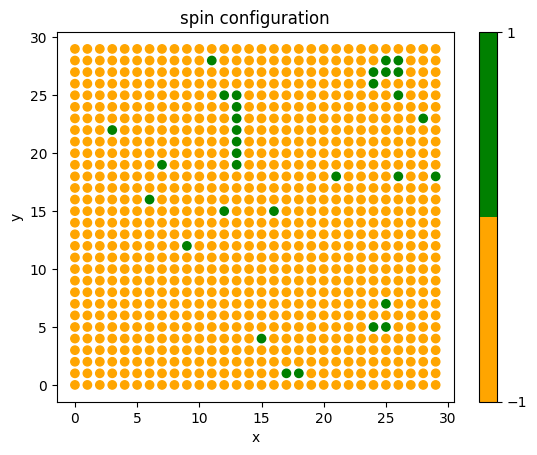

In [ ]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=2000, spin_init='random', sample_equi=True)
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

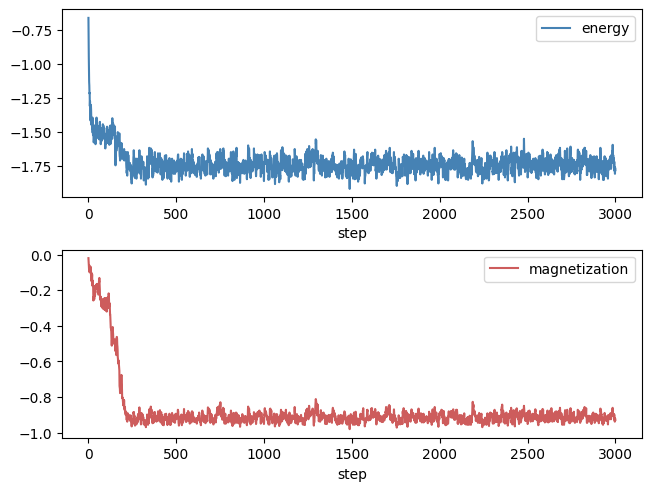

In [ ]:
fig, axs = plt.subplots(nrows=2, layout="constrained")
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

Total number of steps run = 1500.0
Acceptance ratio = 0.608565925925926
Temperature = 4
<E/N> = -0.5570637037037037
<M/N> = 0.0053762962962962966
specific heat = 0.17703724395061324
magnetic susceptibility = 0.2889798591358025


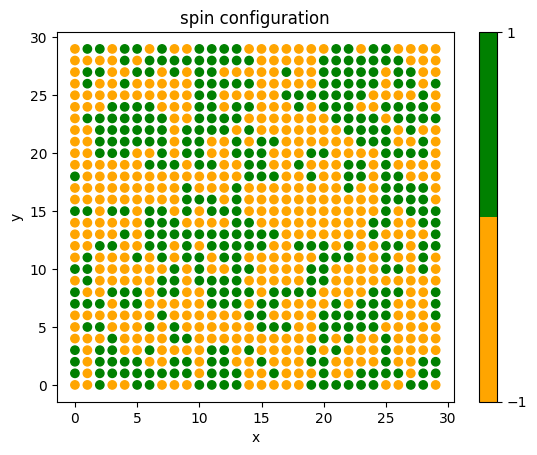

In [ ]:
ising = Ising(L=30, T=4, N_eq=500, N_mcs=1000, spin_init='random', sample_equi=True)
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

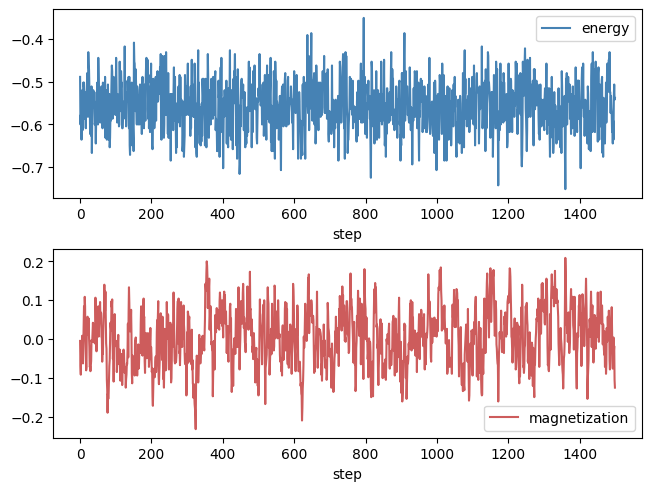

In [ ]:
fig, axs = plt.subplots(nrows=2, layout="constrained")
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

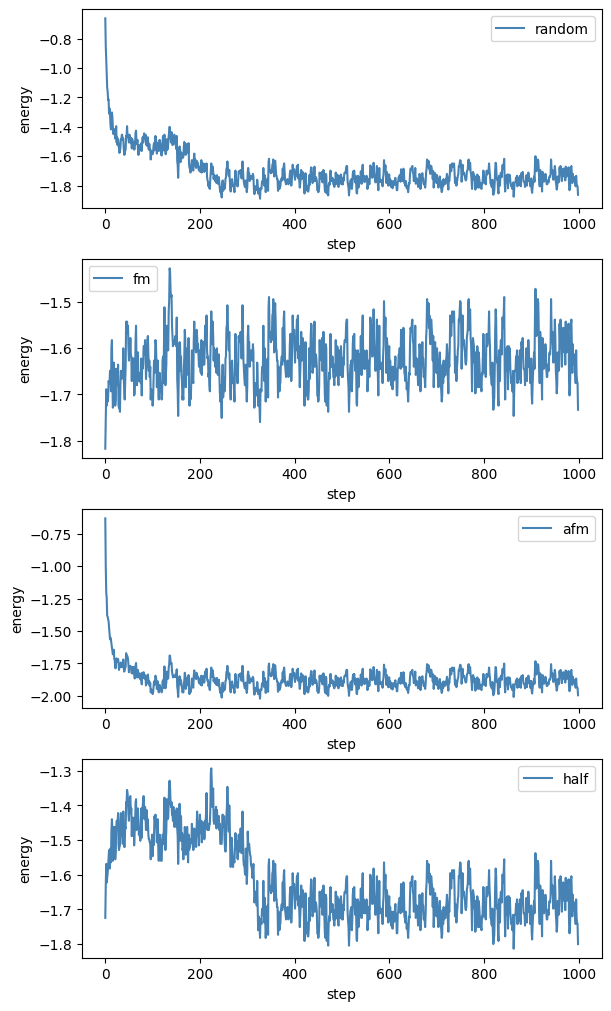

In [ ]:
configurations = ['random', 'fm', 'afm', 'half']

fig, axs = plt.subplots(nrows=4, layout='constrained', figsize=(6,10))

for i in range(4):
    ising = Ising(L=30, T=2, N_eq=1000, N_mcs=0, spin_init=configurations[i], sample_equi=True)
    ising.initialize()
    ising.ising_driver()
    axs[i].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label=f'{configurations[i]}')
    axs[i].legend()
    axs[i].set_xlabel('step')
    axs[i].set_ylabel('energy')

In [ ]:
T_list = np.linspace(1.5,4,30)

res=[]
for T in T_list:
    ising = Ising(L=30, T=T, N_eq=1000, N_mcs=1000, spin_init='random', sample_equi=False, print_stats=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)

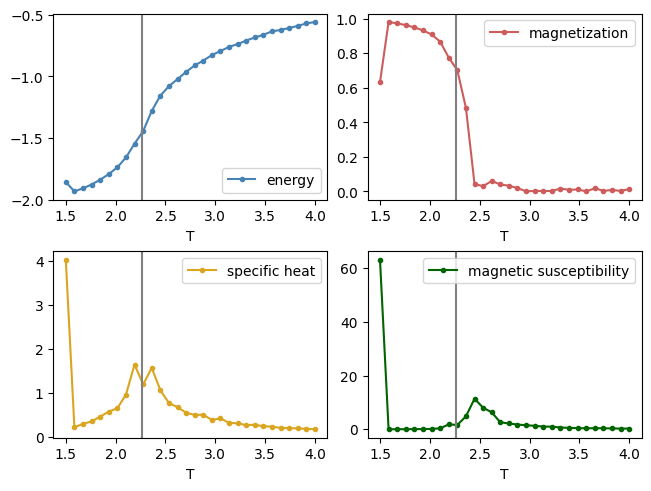

In [ ]:
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2,layout="constrained")
    axs[0,0].plot(T_list,res[:,0],'-o',ms=3,c='steelblue',label='energy')
    axs[0,1].plot(T_list,np.abs(res[:,1]),'-o',ms=3,c='indianred',label='magnetization')
    axs[1,0].plot(T_list,res[:,2],'-o',ms=3,c='goldenrod',label='specific heat')
    axs[1,1].plot(T_list,res[:,3],'-o',ms=3,c='darkgreen',label='magnetic susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.axvline(x=2.26,c='grey')

plot_res(T_list,res)

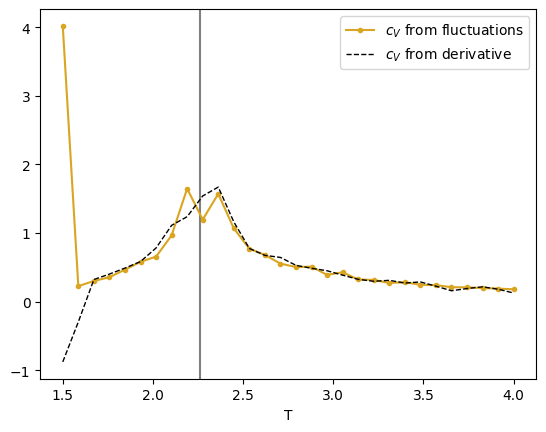

In [ ]:
d2E_dT2 = np.gradient(res[:,0],np.array(T_list))

plt.xlabel('T')
plt.axvline(x=2.26,c='grey')
plt.plot(T_list,res[:,2],'-o',c='goldenrod',ms=3,label=r'$c_V$ from fluctuations')
plt.plot(T_list, d2E_dT2,'--',c='k',lw=1,label=r'$c_V$ from derivative')
plt.legend()

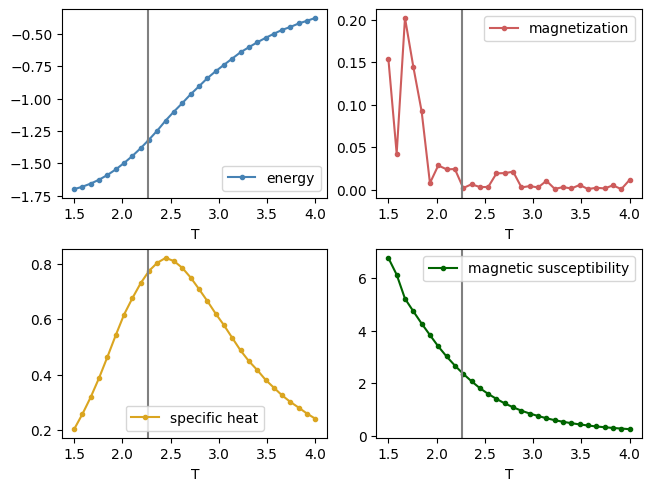

In [ ]:
res=[]
for T in T_list:
    ising = Ising(L=4, T=T, N_eq=1000, N_mcs=100000, spin_init='random', sample_equi=False, print_stats=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)
plot_res(T_list,res)

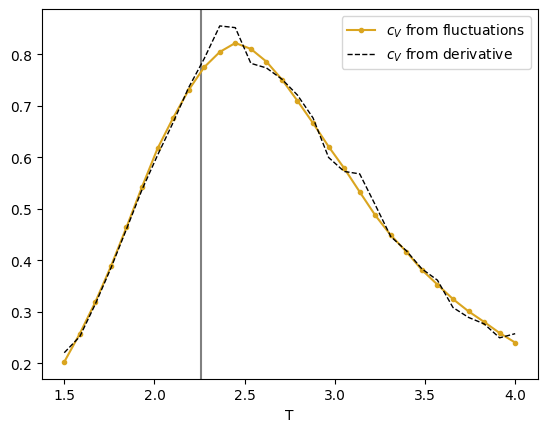

In [ ]:
d2E_dT2 = np.gradient(res[:,0],np.array(T_list))

plt.xlabel('T')
plt.axvline(x=2.26,c='grey')
plt.plot(T_list,res[:,2],'-o',c='goldenrod',ms=3,label=r'$c_V$ from fluctuations')
plt.plot(T_list, d2E_dT2,'--',c='k',lw=1,label=r'$c_V$ from derivative')
plt.legend()

Total number of steps run = 1500.0
Acceptance ratio = 0.11960074074074074
Temperature = 2
<E/N> = -1.3974755555555556
<M/N> = -0.6894088888888888
specific heat = 1.268663893333287
magnetic susceptibility = 3.7233250859259472


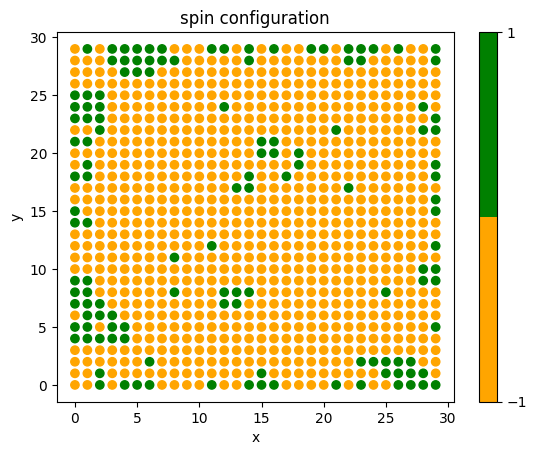

In [ ]:
ising = Ising(L=30, T=2, N_eq=500, N_mcs=1000, boundary='obc', spin_init='random', sample_equi=True)
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

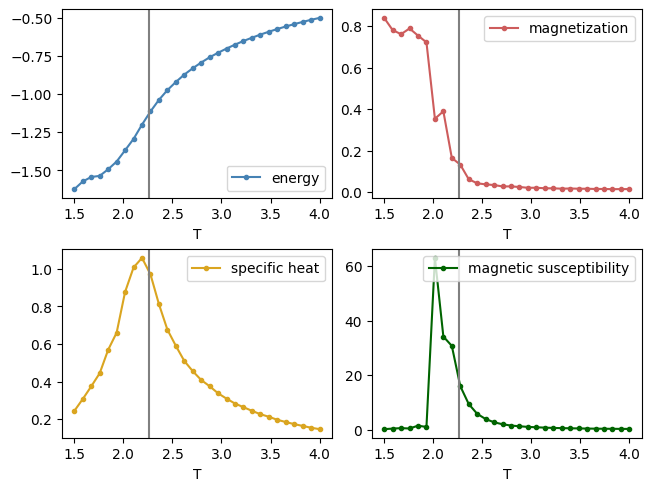

In [ ]:
res=[]
for T in T_list:
    ising = Ising(L=30, T=T, N_eq=1000, N_mcs=100000, boundary='obc', sample_equi=False, print_stats=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)
plot_res(T_list,res)

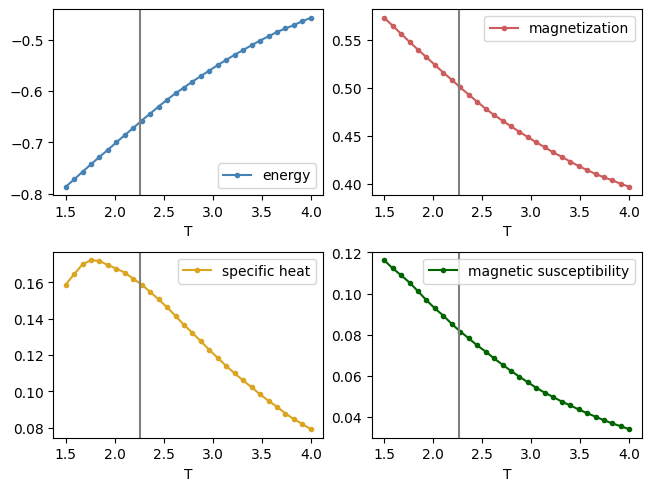

In [ ]:
res=[]
for T in T_list:
    ising = Ising(L=4, T=T, N_eq=1000, N_mcs=100000, boundary='obc', spin_init='random', sample_equi=False, print_stats=False)
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)
plot_res(T_list,res)

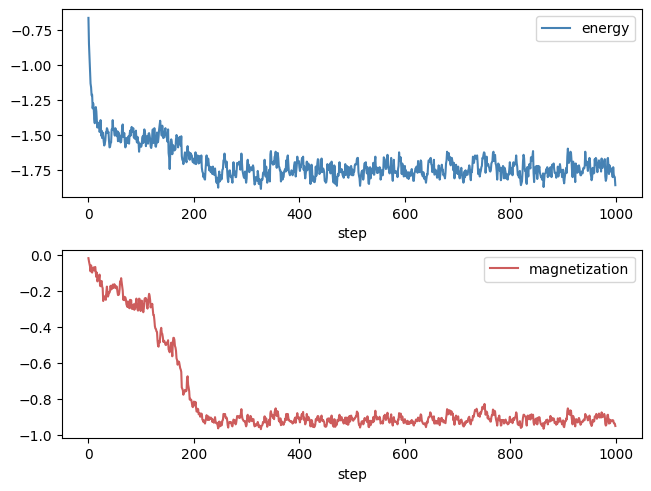

In [ ]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=0, spin_init='random', update_spin='random', sample_equi=True, print_stats=False)
ising.initialize()
ising.ising_driver()

fig, axs = plt.subplots(nrows=2, layout="constrained")
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

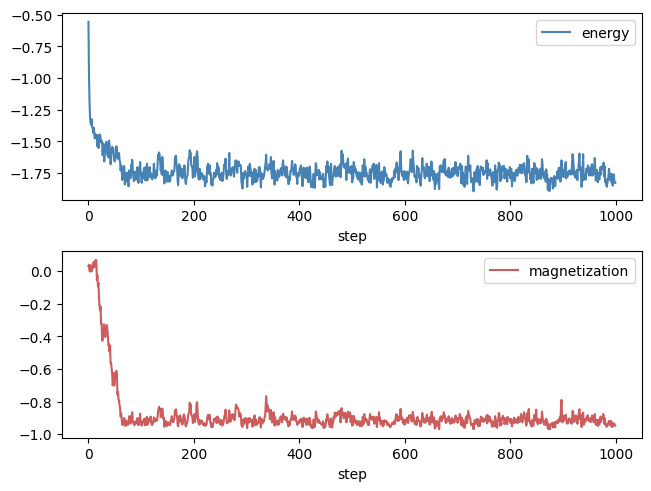

In [ ]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=0, spin_init='random', update_spin='ordered', sample_equi=True, print_stats=False)
ising.initialize()
ising.ising_driver()

fig, axs = plt.subplots(nrows=2, layout="constrained")
axs[0].plot(ising.data[:,0]/ising.N, '-', c='steelblue', label='energy')
axs[1].plot(ising.data[:,1]/ising.N, '-', c='indianred', label='magnetization')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

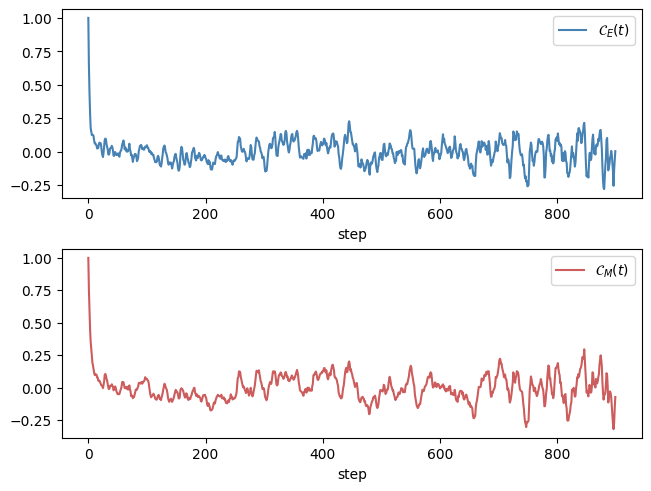

In [ ]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=1000, spin_init='random', update_spin='random', sample_equi=False, print_stats=False)
ising.initialize()
ising.ising_driver()

autocorrE = ising.calc_autocorr(ising.data[:,0], ising.N)
autocorrM = ising.calc_autocorr(ising.data[:,1], ising.N)

fig, axs = plt.subplots(nrows=2, layout="constrained")
axs[0].plot(autocorrE, '-', c='steelblue', label=r'$\mathcal{C}_E(t)$')
axs[1].plot(autocorrM, '-', c='indianred', label=r'$\mathcal{C}_M(t)$')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')

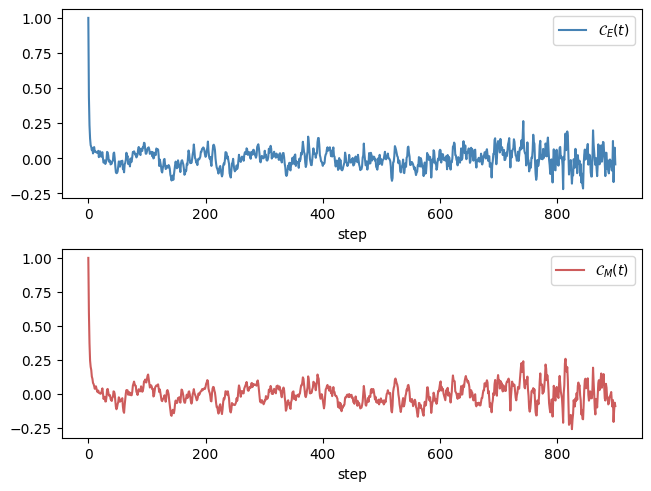

In [ ]:
ising = Ising(L=30, T=2, N_eq=1000, N_mcs=1000, spin_init='random', update_spin='ordered', sample_equi=False, print_stats=False)
ising.initialize()
ising.ising_driver()

autocorrE = ising.calc_autocorr(ising.data[:,0], ising.N)
autocorrM = ising.calc_autocorr(ising.data[:,1], ising.N)

fig, axs = plt.subplots(nrows=2, layout="constrained")
axs[0].plot(autocorrE, '-', c='steelblue', label=r'$\mathcal{C}_E(t)$')
axs[1].plot(autocorrM, '-', c='indianred', label=r'$\mathcal{C}_M(t)$')
for ax in axs:
    ax.legend()
    ax.set_xlabel('step')